In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
from pathlib import Path
warnings.filterwarnings("ignore")

In [3]:
# 自定义的路径
path = Path.cwd().parent/'tcdata'

#####train
trn_click = pd.read_csv(path/'train_click_log.csv')
#trn_click = pd.read_csv(path+'train_click_log.csv', names=['user_id','item_id','click_time','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'])
item_df = pd.read_csv(path/'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名article_id，方便后续match
item_emb_df = pd.read_csv(path/'articles_emb.csv')

#####test
tst_click = pd.read_csv(path/'testA_click_log.csv')

In [4]:
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
# .goupby(['col1'])['col2']表示对'col1'的'col2'分组,然后再组内排名
# 这样会新增加一列 rank ,上面的数字就是他时间戳的排名
#print(trn_click.head())
#trn_click.groupby(['user_id'])['click_timestamp'].tail(3)

In [5]:
np.random.seed(42)  # 设置全局随机种子
df = pd.DataFrame(
       {
           "A": ["foo", "bar", "foo", "bar", "foo", "bar", "foo", "foo"],
           "B": ["one", "one", "two", "three", "two", "two", "one", "three"],
           "C": np.random.randn(8),
           "D": np.random.randn(8),
       }
   )
print(df)  
df['rank'] = df.groupby(['A'])['C'].rank(ascending=False).astype(int)
df

     A      B         C         D
0  foo    one  0.496714 -0.469474
1  bar    one -0.138264  0.542560
2  foo    two  0.647689 -0.463418
3  bar  three  1.523030 -0.465730
4  foo    two -0.234153  0.241962
5  bar    two -0.234137 -1.913280
6  foo    one  1.579213 -1.724918
7  foo  three  0.767435 -0.562288


,A,B,C,D,rank
0,foo,one,0.496714,-0.469474,4
1,bar,one,-0.138264,0.542560,2
2,foo,two,0.647689,-0.463418,3
3,bar,three,1.523030,-0.465730,1
4,foo,two,-0.234153,0.241962,5
5,bar,two,-0.234137,-1.913280,3
6,foo,one,1.579213,-1.724918,1
7,foo,three,0.767435,-0.562288,2


In [6]:
#计算每一个用户点击文章的次数，并添加新的一列count,用户有几个时间戳就再新的一列添加点击次数
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')
#print(trn_click.head())

In [7]:
# .groupby(['user_id'])['click_timestamp'].transform('count')

df = pd.DataFrame({
    'user_id': [1, 1, 1, 2, 2],
    'click_time': [100, 400, 300, 150, 250],
    'item_id': ['A', 'B', 'C', 'D', 'E']
})

# 添加：每个用户的首次点击时间
df['click_times'] = df.groupby('user_id')['click_time'].transform('count')#transform('count')输出长度与原序列长度一样,根据用户id计算
# click_times的次数,结果放在每一用户的最新一行

# 添加：每个用户的点击序号
df['click_order'] = df.groupby('user_id')['click_time'].transform(
    lambda x: x.rank(method='first')
).astype(int)

print(df)

   user_id  click_time item_id  click_times  click_order
0        1         100       A            3            1
1        1         400       B            3            3
2        1         300       C            3            2
3        2         150       D            2            1
4        2         250       E            2            2


In [8]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
# trn_click 会新增来自 item_df 的所有列
# 如果某 click_article_id 在 item_df 中不存在 → 对应行新增列为 NaN
# 原有 trn_click 的所有行都会保留（因为是 how='left'）
print(len(trn_click))
trn_click.head()

1112623


,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [9]:
#用户点击日志信息
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int32
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int32(1), int64(13)
memory usage: 114.6 MB


In [10]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [11]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()
# .unique()对Series数据去重,返回为去重后的list
# .nuique()对Series数据去重,返回为去重后的list的长度

200000

In [12]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章
# 检查每一个用户至少点击了多少篇新闻
#.count()


# df = pd.DataFrame({
#     'A': [1, 2, np.nan],
#     'B': [4, np.nan, 6],
#     'C': [7, 8, 9]
# })

# print(df.count()) .count 计算每种类别非NaN数据个数
# 输出:
# A    2
# B    2
# C    3
# dtype: int64

2

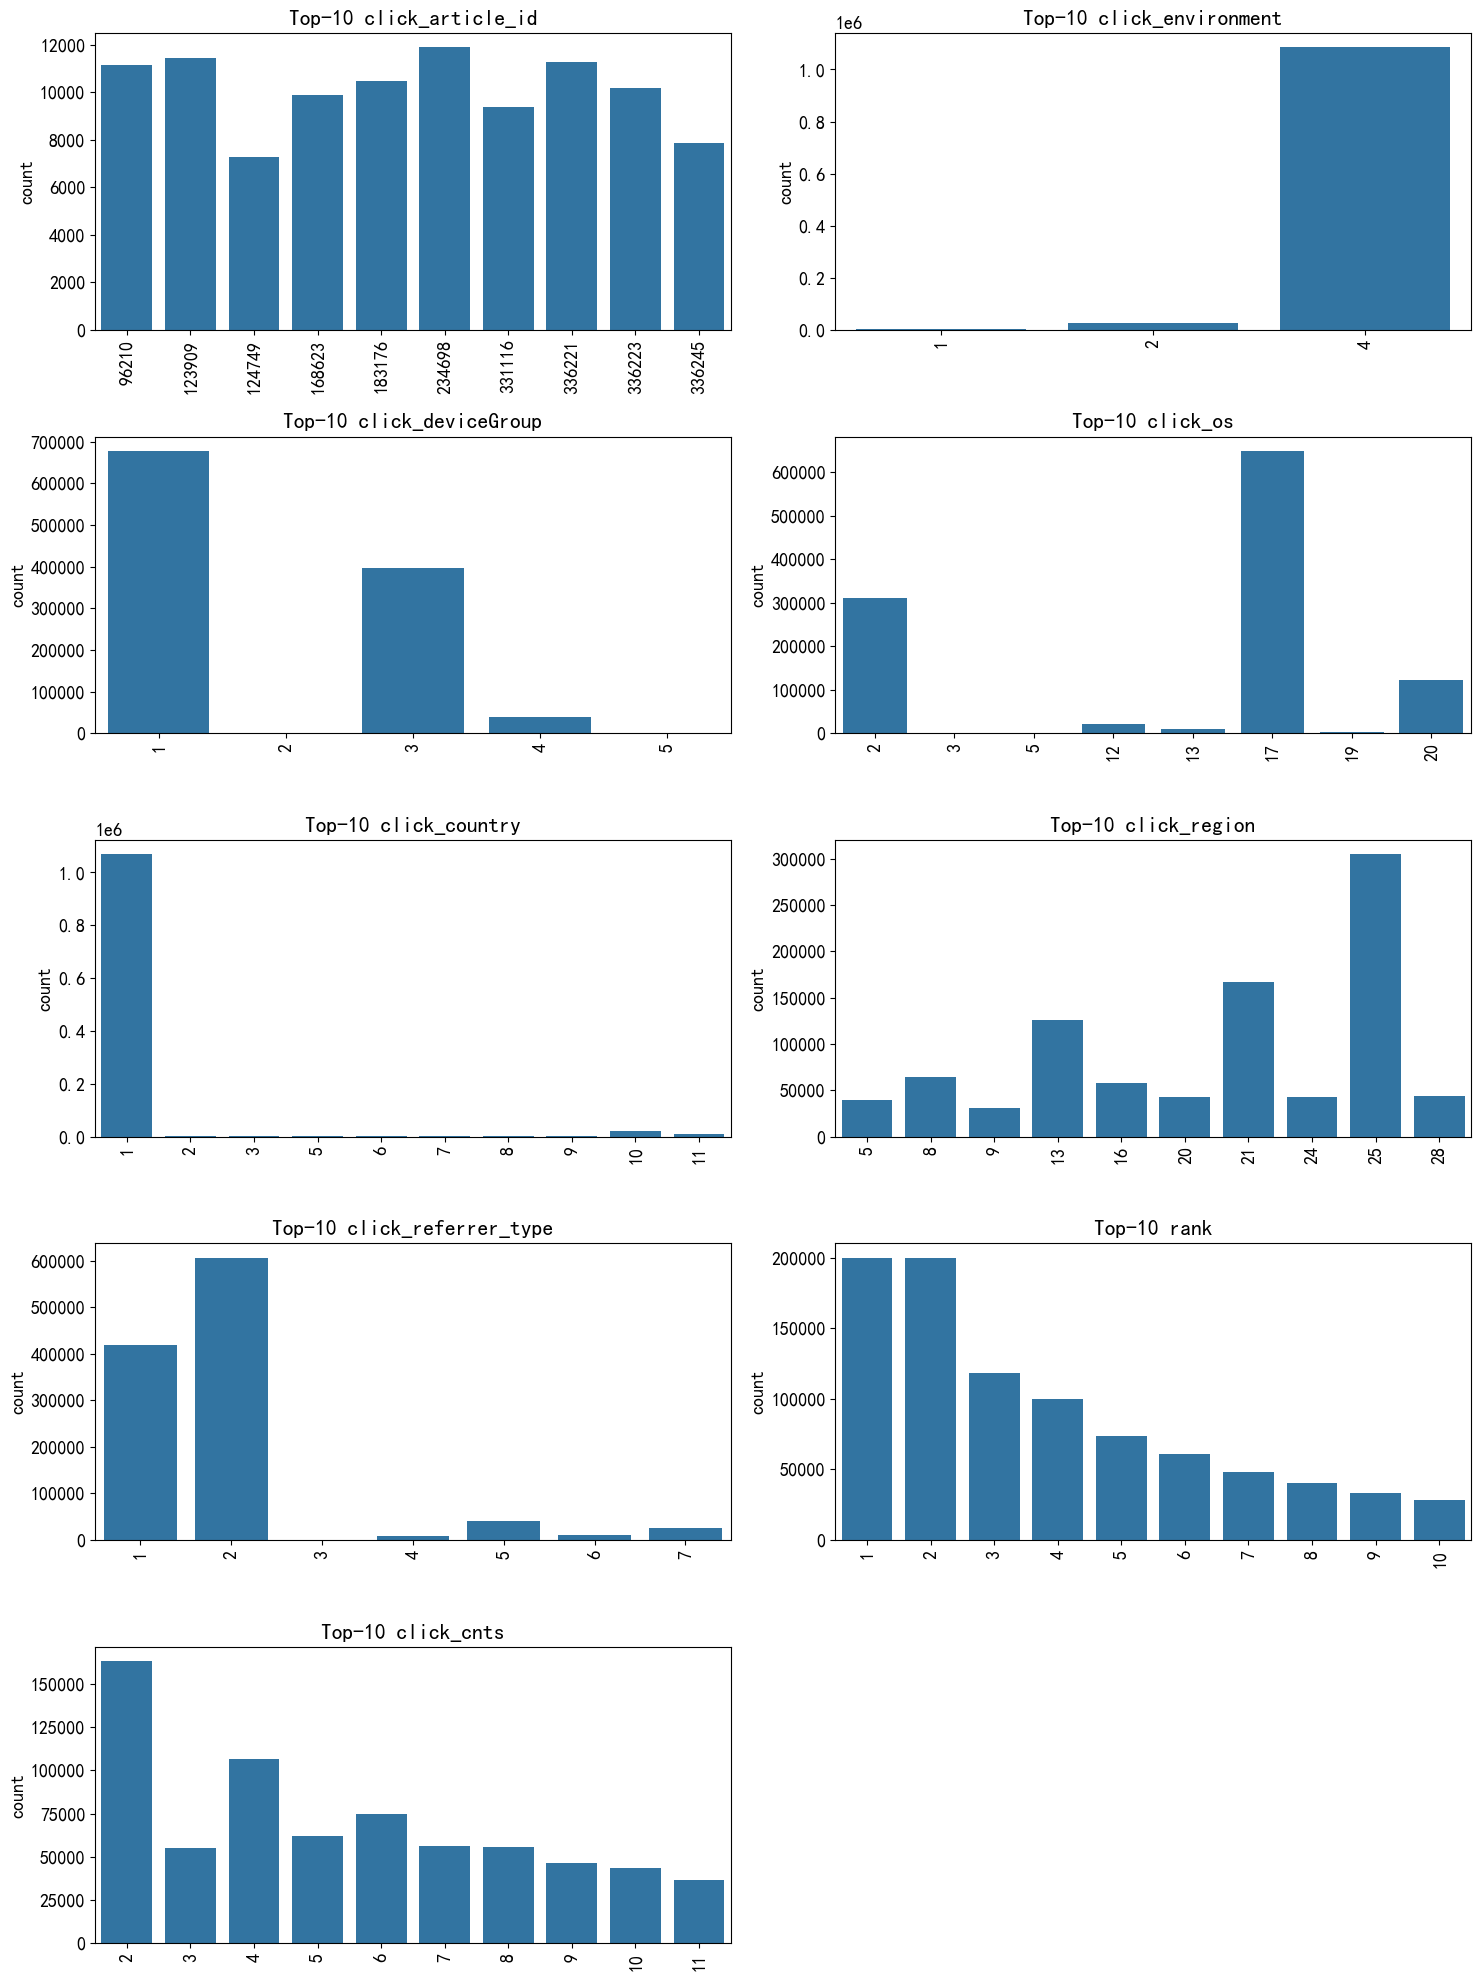

In [13]:
plt.figure(figsize=(15, 20)) # 总画布大小

cols = ['click_article_id', 'click_environment', 'click_deviceGroup', 
        'click_os', 'click_country', 'click_region', 'click_referrer_type', 
        'rank', 'click_cnts']

for i, col in enumerate(cols, 1): # 表示 i 从1开始,这是plt要求的,subplot 索引不能为 0
    plt.subplot(5, 2, i)
    
    # 计算 Top-10 值
    v = trn_click[col].value_counts().reset_index()
    # 注意：这要求 value_counts() 返回的是 Series，而 reset_index 的 name 参数用于指定值列名
    # 假设 col = 'click_os'
# value_counts() → 
#   Android    5000
#   iOS        3000
#   Web        2000
# reset_index() → 
#      index  click_os
# 0  Android      5000
# 1      iOS      3000
# 2      Web      2000
    v.columns = ['value', 'count']  # 显式命名，避免因默认名导致的错误
    
    v = v.head(10)  # 只保留前10个值,没有10个类别就返回全部类别
    
    # 绘制柱状图
    sns.barplot(data=v, x='value', y='count')
    plt.xticks(rotation=90)
    plt.title(f'Top-10 {col}')
    plt.xlabel('')  # 可选：隐藏x轴标签文字以节省空间

plt.tight_layout()
plt.show()

In [14]:
# 可知click_environment只有3个类别,为4,2,1
trn_click['click_environment'].nunique(),trn_click['click_environment'].unique()

(3, array([4, 1, 2], dtype=int64))

In [15]:
print(trn_click['click_environment'].value_counts(normalize=True))# 可以知道4 的点击环境人数最多 normalize=True 表示转换为小数
trn_click['click_environment'].count() # 返回的是click_environment 非空 no-null个数

click_environment
4    0.974838
2    0.023273
1    0.001889
Name: proportion, dtype: float64


1112623

In [16]:
trn_click['click_deviceGroup'].value_counts(normalize=True) # 可知1的点击设备最多

click_deviceGroup
1    0.609539
3    0.355518
4    0.034811
5    0.000127
2    0.000005
Name: proportion, dtype: float64

In [17]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [18]:
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


In [19]:
#测试集中的用户数量为5w
tst_click.user_id.nunique()


50000

In [20]:
tst_click.groupby('user_id')['click_article_id'].count().min() # 注意测试集里面有只点击过一次文章的用户

1

In [21]:
#新闻文章数据集浏览 
pd.concat([item_df.head(),item_df.tail()],ignore_index=True)

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
5,364042,460,1434034118000,144
6,364043,460,1434148472000,463
7,364044,460,1457974279000,177
8,364045,460,1515964737000,126
9,364046,460,1505811330000,479


In [56]:
print(item_df['words_count'].value_counts(normalize=False).describe())
item_df['words_count'].value_counts(normalize=False)# 可知文章字数共有866种,大部分文章字数再1-194

count     866.000000
mean      420.377598
std       890.024317
min         1.000000
25%         1.000000
50%         7.000000
75%       194.500000
max      3485.000000
Name: count, dtype: float64


words_count
176     3485
182     3480
179     3463
178     3458
174     3456
        ... 
556        1
625        1
2798       1
767        1
841        1
Name: count, Length: 866, dtype: int64

461
6.133398042996649 0.0


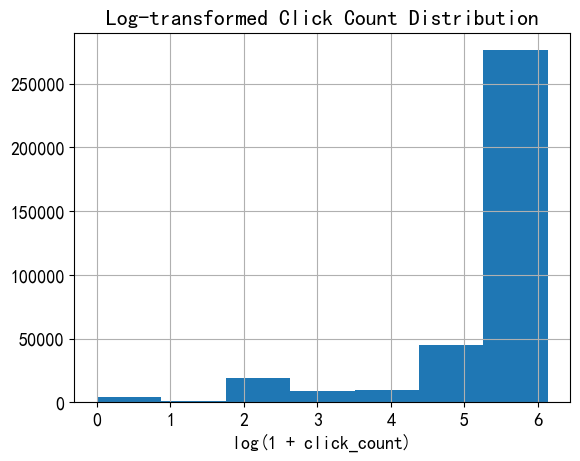

In [61]:
print(item_df['category_id'].nunique())     # 461个文章主题
#item_df['category_id'].hist()
print(item_df['category_id'].max(),item_df['category_id'].min())
item_df['category_id'].hist(bins=7)
#item_df['category_id'] = np.log1p(item_df['category_id'])  # log(1 + x)，避免 log(0)

plt.title('Log-transformed Click Count Distribution')
plt.xlabel('log(1 + click_count)')
plt.show()
## 可以知道

Text(0, 0.5, 'Frequency')

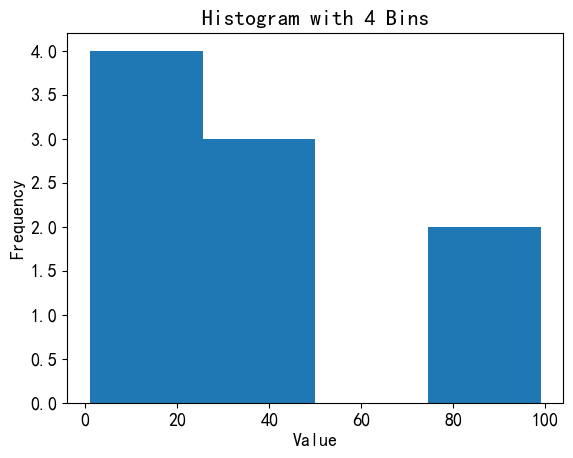

In [24]:
# 数据集
data = [1,99,32,44,88,3,4,5,33]

# 绘制直方图
plt.hist(data, bins=4)

# 添加标题和轴标签
plt.title('Histogram with 4 Bins')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [25]:
item_df.shape       # 364047篇文章

(364047, 4)

In [26]:
item_emb_df.head()


,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [27]:
item_emb_df.shape

(364047, 251)

In [28]:
user_click_merge = pd.concat([trn_click,tst_click],ignore_index=True)

In [ ]:
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]
# 是统计每个用户对每篇文章的点击次数（即 (user_id, click_article_id) 组合下 click_timestamp 出现的次数）

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [63]:
user_click_count[user_click_count['count']>7] # 找出对文章点击超过7次的用户以及相对应的文章

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [64]:
user_click_count['count'].unique()# 新闻点击次数有如下几种

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13], dtype=int64)

In [65]:
#用户点击新闻次数
user_click_count.loc[:,'count'].value_counts() 

count
1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

In [66]:
def plot_envs(df, cols, r, c):
    plt.figure(figsize=(12, 8))
    #i = 1
    for i,col in enumerate(cols,1):
        plt.subplot(r, c, i)
        #i += 1
        
        #  显式重命名，确保列名可控
        value_counts = df[col].value_counts()
        v = value_counts.reset_index()
        v.columns = [col, 'count']  # 强制设置列名
        
        ax = sns.barplot(data=v, x=col, y='count')
        
        for item in ax.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    
    plt.tight_layout()
    plt.show()

2025-11-25 22:58:30,239:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,243:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,260:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,264:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,280:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 10818


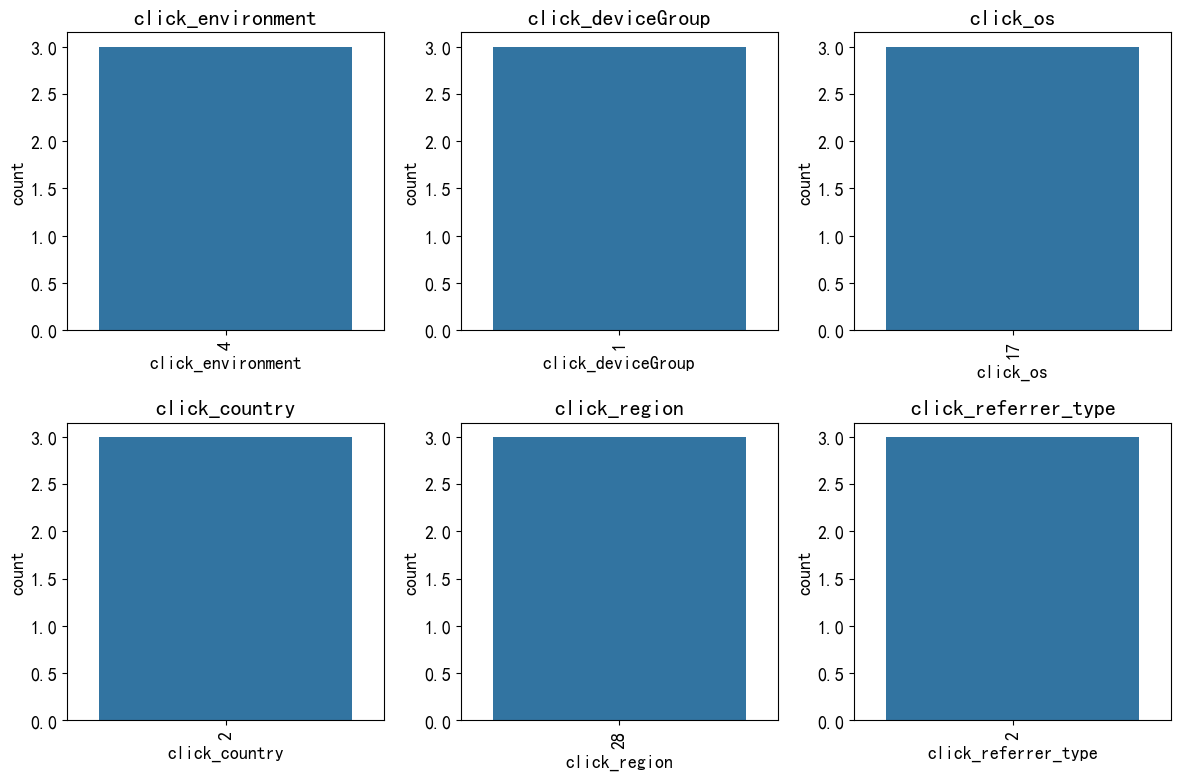

2025-11-25 22:58:30,585:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,589:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,603:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,609:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,630:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 41794


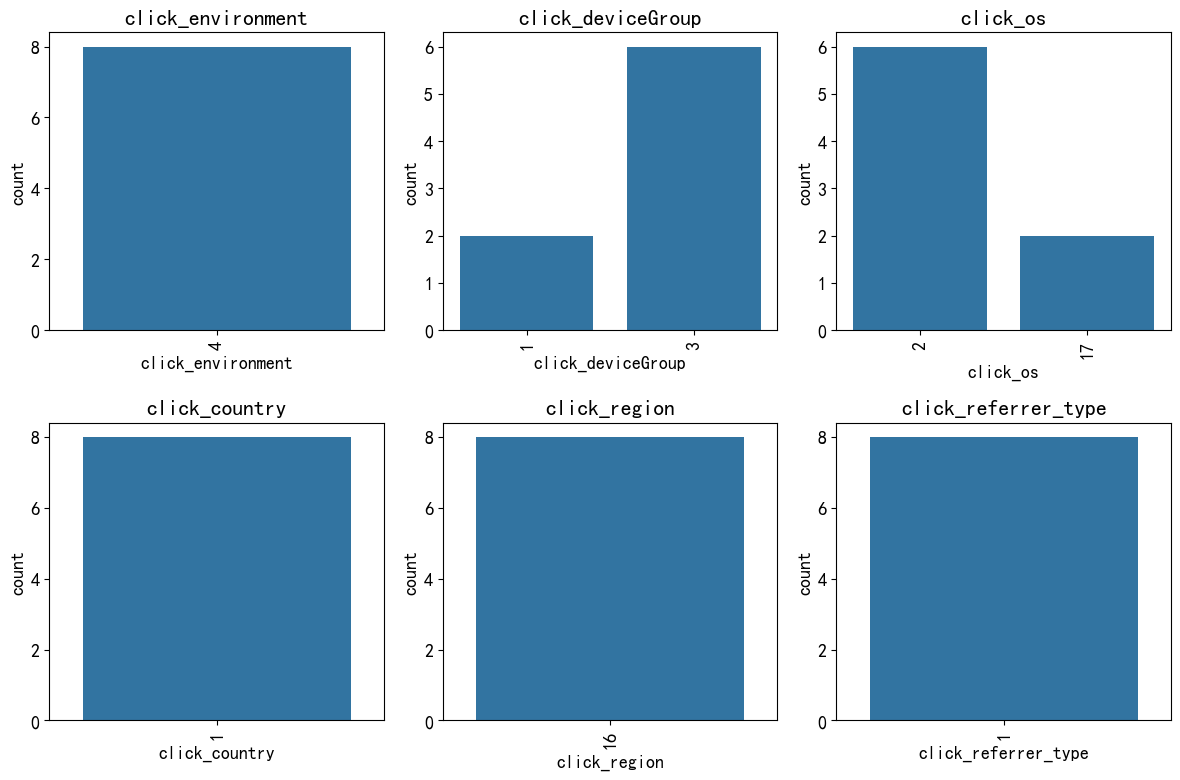

2025-11-25 22:58:30,913:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,917:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,939:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,943:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:30,958:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 85477


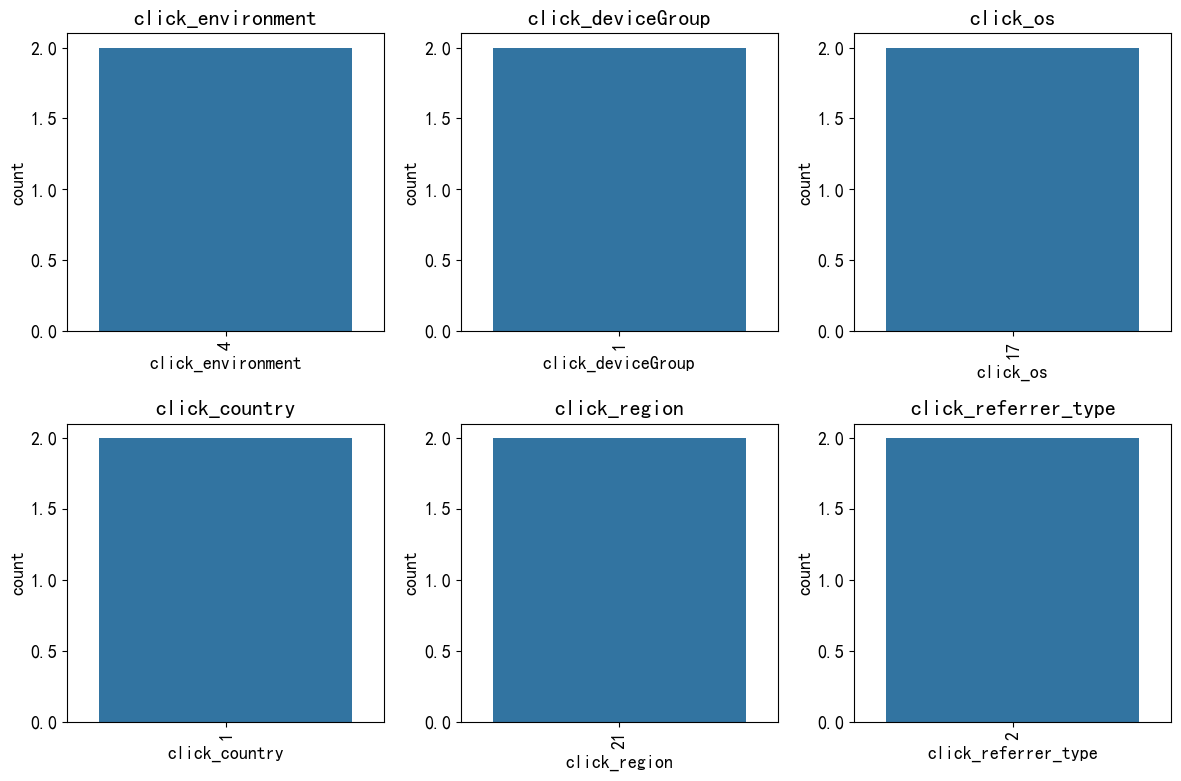

2025-11-25 22:58:31,227:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,231:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,246:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,251:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,272:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 90826


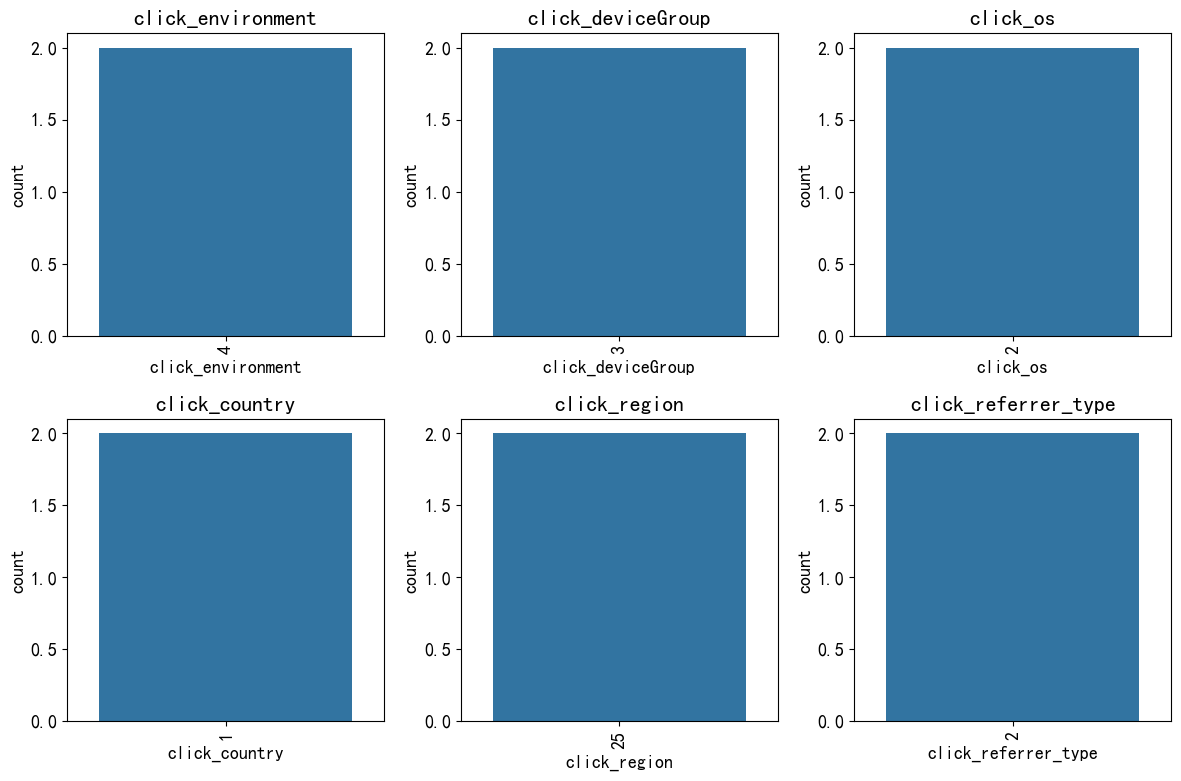

2025-11-25 22:58:31,549:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,553:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,570:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,575:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,596:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 106577


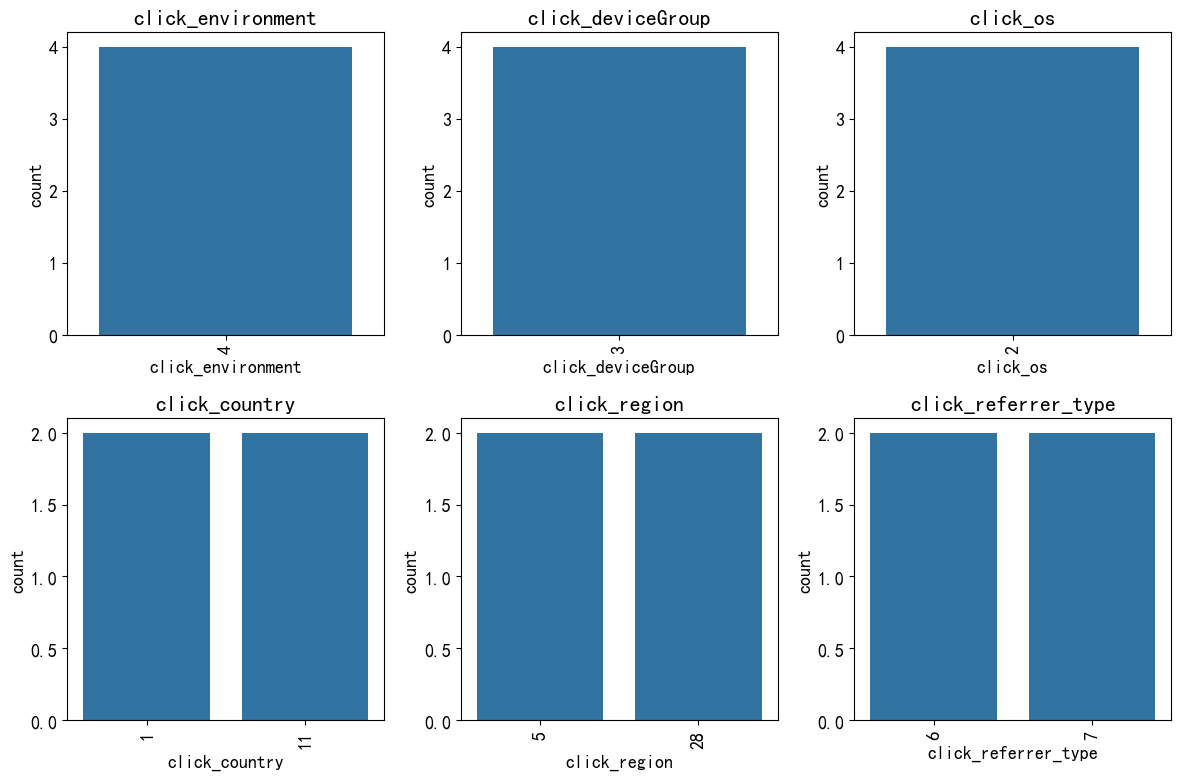

2025-11-25 22:58:31,883:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,886:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,901:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,907:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:31,927:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 131008


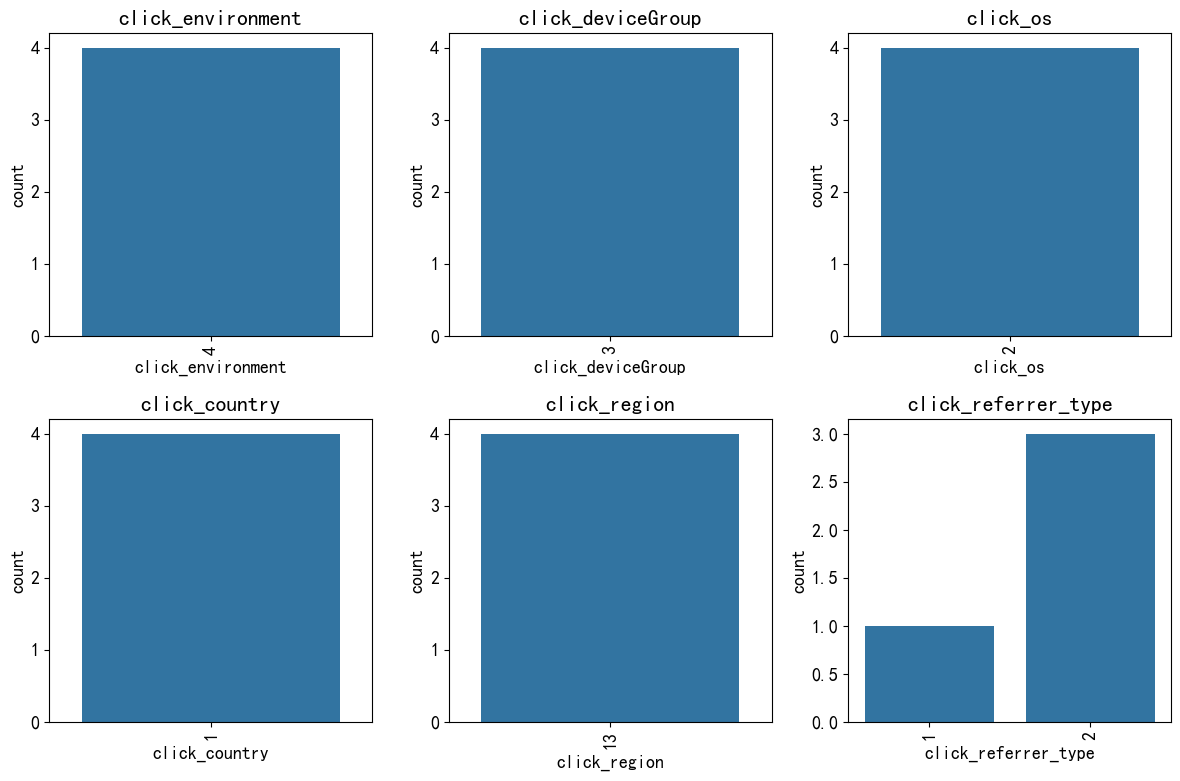

2025-11-25 22:58:32,222:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,226:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,243:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,247:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,267:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 134987


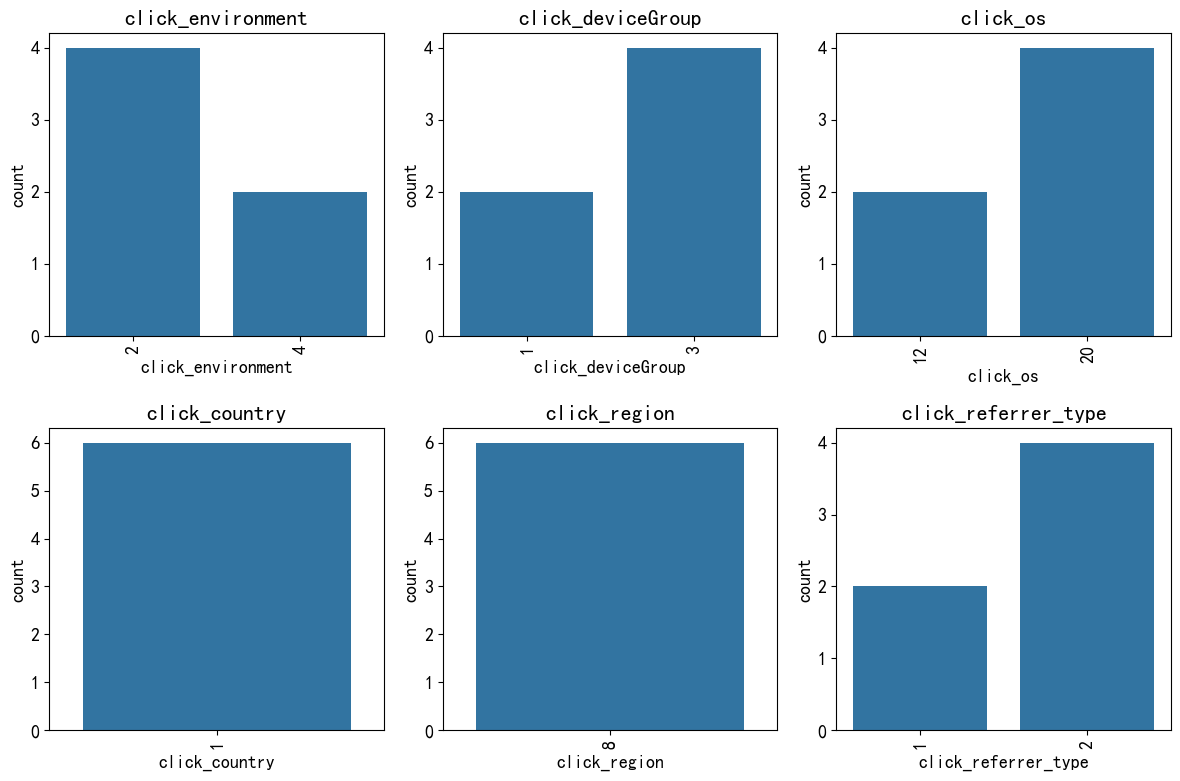

2025-11-25 22:58:32,553:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,556:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,574:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,579:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,599:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 170733


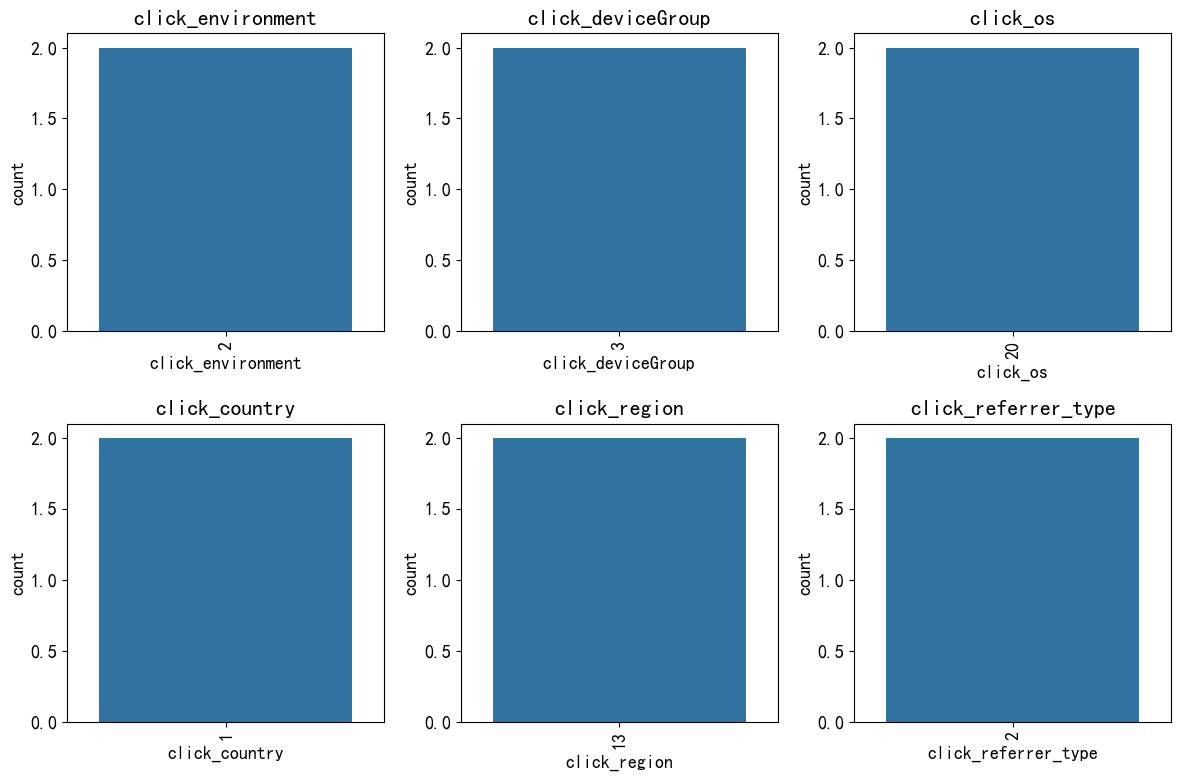

2025-11-25 22:58:32,884:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,888:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,904:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:32,908:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,054:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 227650


2025-11-25 22:58:33,081:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,099:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,104:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,123:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,127:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

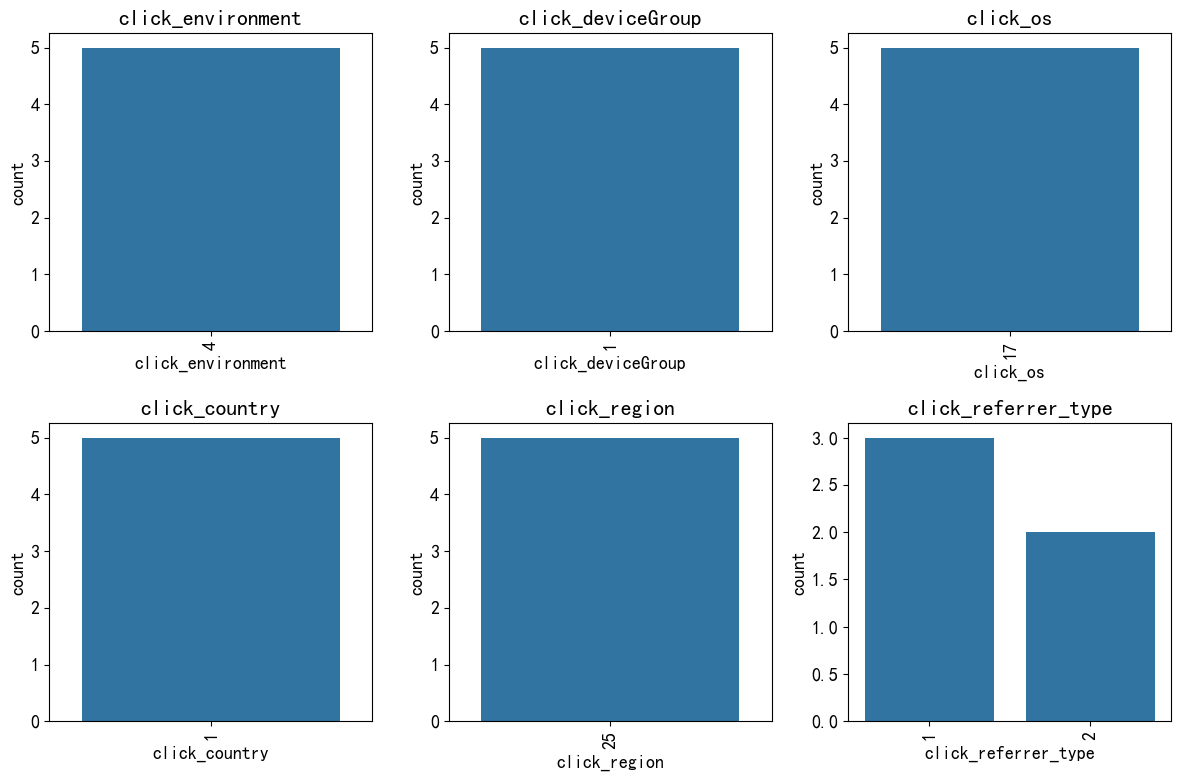

2025-11-25 22:58:33,371:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,376:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,396:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,403:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-25 22:58:33,424:INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

User ID: 246223


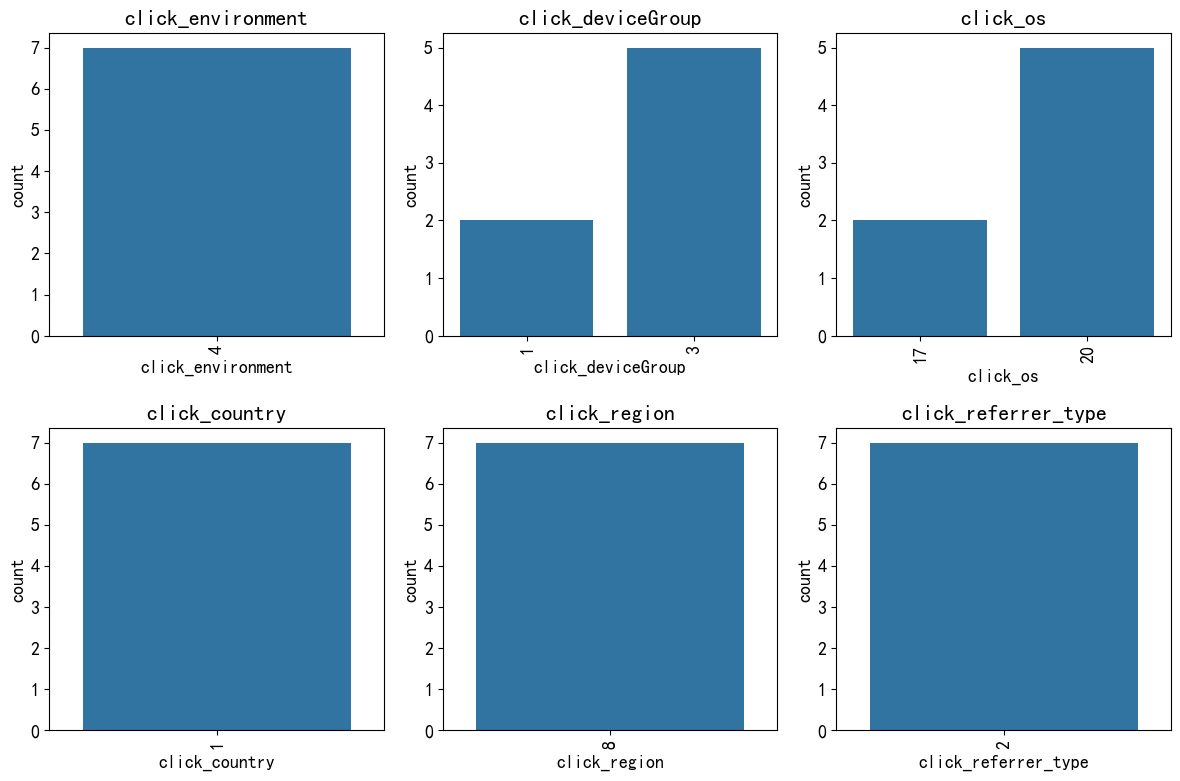

In [67]:
# 随机采样 10 个用户
sample_user_ids = np.random.choice(
    user_click_merge['user_id'].unique(), 
    size=10, 
    replace=False
)

sample_users = user_click_merge[
    user_click_merge['user_id'].isin(sample_user_ids)
]

cols = [
    'click_environment', 'click_deviceGroup', 'click_os',
    'click_country', 'click_region', 'click_referrer_type'
]

# 对每个用户绘制环境分布
for user_id, user_df in sample_users.groupby('user_id'):
    print(f"User ID: {user_id}")
    plot_envs(user_df, cols, r=2, c=3)

user_id
249322    938
242546    782
239302    361
245163    326
240519    259
         ... 
200310      1
239298      1
239368      1
200196      1
218636      1
Name: count, Length: 250000, dtype: int64


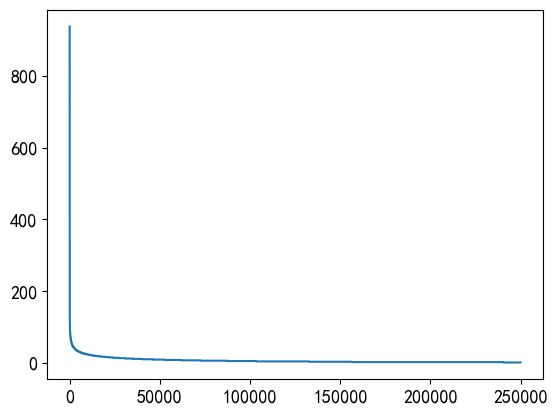

In [74]:
# 排序 每个用户点击文章的次数,根据图可以知道绝大多数人点击文章次数小于1000,这个图没什么意义
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
#user_click_merge.groupby('user_id')['click_article_id'].count()查看用户点击的文章次数



#print(user_click_merge.groupby('user_id')['click_article_id'].value_counts())
print(user_click_merge['user_id'].value_counts())# 可知用户点击文章次数最多是938次
plt.plot(user_click_item_count)


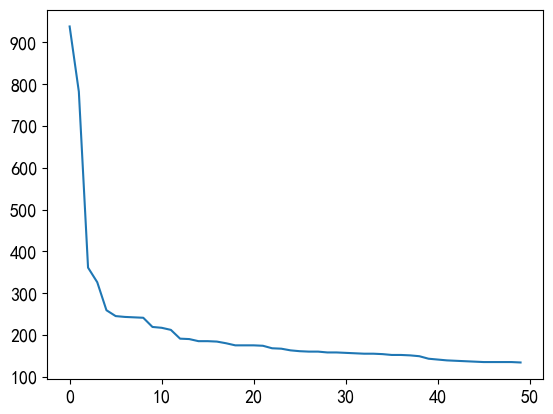

In [75]:
#点击次数在前50的用户,可以知道大部分用户点击文章次数小于10
plt.plot(user_click_item_count[:50])

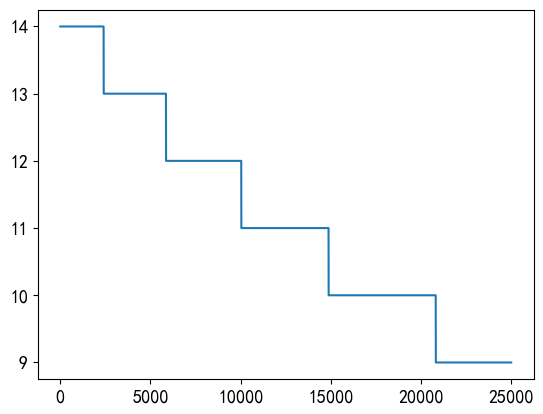

In [76]:
#点击次数排名在[25000:50000]之间
plt.plot(user_click_item_count[25000:50000])

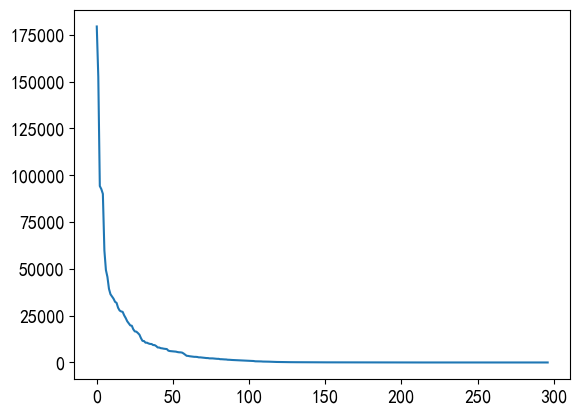

In [38]:
#不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

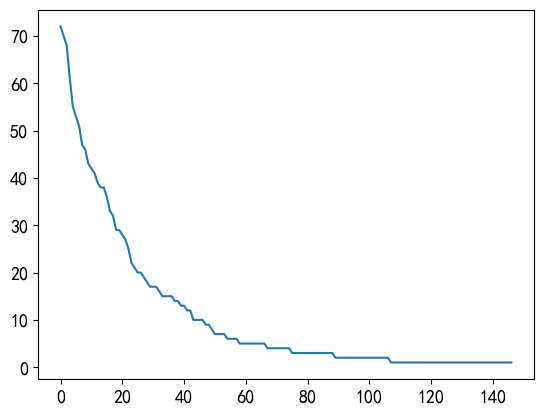

In [77]:
#出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次,根据图可知id[0-150]的新闻类型出现最多
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [79]:
#新闻字数的描述性统计,可以知道字数再 0-229的文章出现次数最多
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

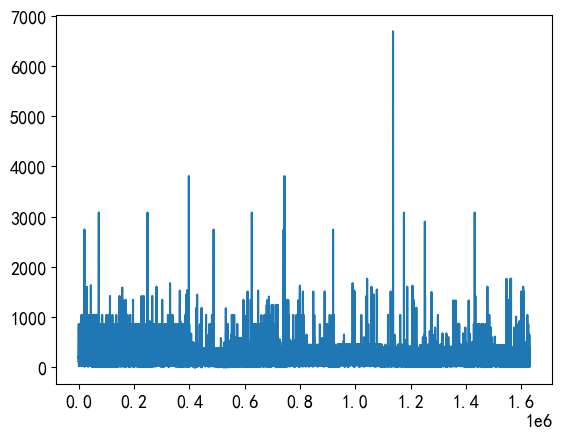

In [80]:
plt.plot(user_click_merge['words_count'].values)

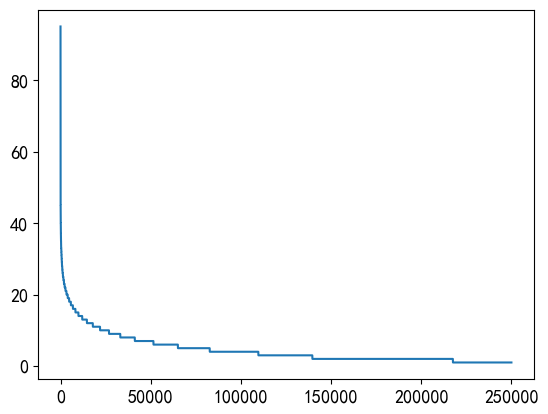

In [82]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))
# 绘制了每个用户所涉猎的内容类别数量（去重），并按从多到少排序，用于分析用户兴趣的多样性分布

In [83]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()
# 可知,用户对0-6号文章类型感兴趣


,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


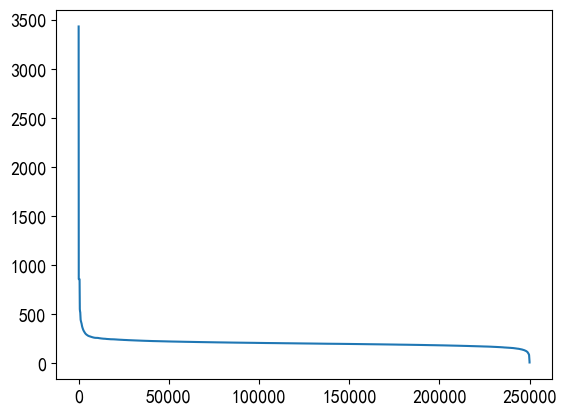

In [84]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))

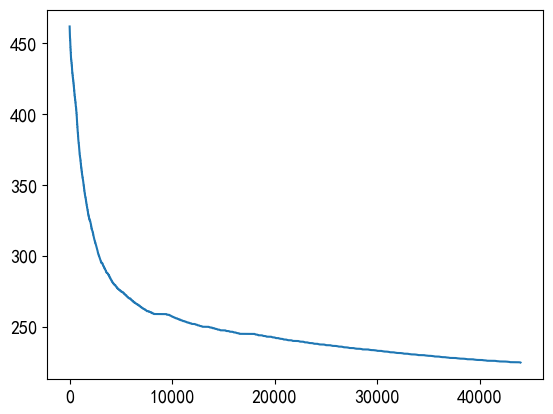

In [85]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])
# 大部分用户喜欢读取字数 250-450的文章



In [86]:
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge = user_click_merge.sort_values('click_timestamp')
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
1112641,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
1112625,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
1112653,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
1112673,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
1112648,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


In [95]:
def mean_diff_time_func(df, col):
    df = pd.DataFrame(df, columns={col})
    df['time_shift1'] = df[col].shift(1).fillna(0)# 对每一列求该行与前面一行的时间差,出现NaN就填写0
    df['diff_time'] = abs(df[col] - df['time_shift1']) # 把差值改为 绝对值
    return df['diff_time'].mean() # 返回某列差值的绝对值

In [100]:
from gensim.models import Word2Vec
import logging, pickle

#需要注意这里模型只迭代了一次
def trian_item_word2vec(click_df, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # 只有转换成字符串才可以进行训练
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    #click_df['click_article_id'] = click_df['click_article_id'].unique()
    # 转换成句子的形式
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # 为了方便查看训练的进度，这里设定一个log信息
    #logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # 这里的参数对训练得到的向量影响也很大,默认负采样为5
    w2v = Word2Vec(docs, vector_size=16, sg=1, window=5, seed=2020, workers=24, min_count=1, epochs=10)
    
    # 保存成字典的形式
    
    item_w2v_emb_dict = {k: w2v.wv[k] for k in click_df['click_article_id'].unique()}
    
    return item_w2v_emb_dict


    
 

In [102]:
item_w2v_emb_dict = trian_item_word2vec(user_click_merge) #这段代码正是对 click_article_id（文章ID）进行 embedding（嵌入表示）

2025-11-25 23:33:11,703:INFO:collecting all words and their counts
2025-11-25 23:33:11,704:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-11-25 23:33:11,711:INFO:PROGRESS: at sentence #10000, processed 25727 words, keeping 3473 word types
2025-11-25 23:33:11,718:INFO:PROGRESS: at sentence #20000, processed 53883 words, keeping 5811 word types
2025-11-25 23:33:11,729:INFO:PROGRESS: at sentence #30000, processed 84881 words, keeping 7676 word types
2025-11-25 23:33:11,740:INFO:PROGRESS: at sentence #40000, processed 118390 words, keeping 9297 word types
2025-11-25 23:33:11,754:INFO:PROGRESS: at sentence #50000, processed 154179 words, keeping 10844 word types
2025-11-25 23:33:11,767:INFO:PROGRESS: at sentence #60000, processed 192350 words, keeping 12357 word types
2025-11-25 23:33:11,778:INFO:PROGRESS: at sentence #70000, processed 233685 words, keeping 13473 word types
2025-11-25 23:33:11,793:INFO:PROGRESS: at sentence #80000, processed 281335 words, keepin

In [90]:
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
1140374,239051,160974,0.002400,4,3,2,1,25,1,18,18,281,0.989092,259
1140375,239051,160417,0.002474,4,3,2,1,25,1,17,18,281,0.989178,173
1140376,239051,156808,0.002482,4,3,2,1,25,1,16,18,281,0.989155,227
8345,196977,160974,0.020951,4,3,20,1,16,1,2,2,281,0.989092,259
8346,196977,166338,0.020960,4,3,20,1,16,1,1,2,289,0.989401,217


In [103]:
# 上一个版本，这个函数使用的是赛题提供的词向量，但是由于给出的embedding并不是所有的数据的embedding，所以运行下面画图函数的时候会报keyerror的错误
# 为了防止出现这个错误，这里修改为使用word2vec训练得到的词向量进行可视化
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values
    for i in range(0, len(item_list)-1):
        emb1 = item_w2v_emb_dict[str(item_list[i])] # 需要注意的是word2vec训练时候使用的是str类型的数据
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    sim_list.append(0)
    return sim_list

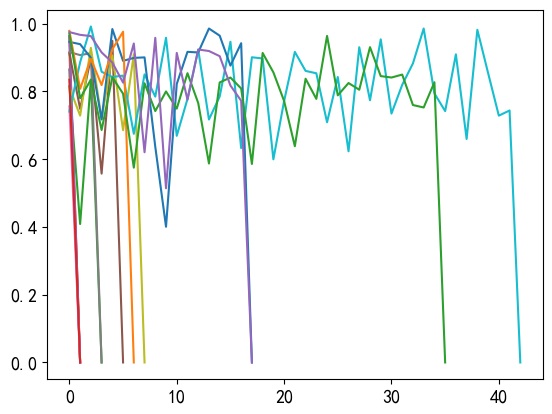

In [104]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)
    